# Notebook 4: Connecting the underlying transmission model and the observed data

In notebook 3 we introduced the underlying transmission model. However, the actual dynamical state of the epidemic in a Kenyan county is not observable, instead we observe events that related to infection like testing PCR-positive for the presence of SARS-CoV-2 genetic material (swab tests) or SARS-CoV-2 specific antibodies (serology tests). In this notebook we cover:

* Translating the continuous time prediction of the ODE model into a discrete time prediction of daily infections.
* The delay distributions between infection and an observable event:
    - Time between infection and chance of being PCR detectable
    - Time between infection and chance of being serologically detectable
    - Time between infection and death, for those who die.
* Combining the daily infections and the daily distributions to give daily estimates of the number of observable people who have been infected exist in the population.

To start with solve the ODE problem for Nairobi using our posterior mean estimates, as we introduced in notebook 3.

In [19]:
cd(joinpath(homedir(),"GitHub/KenyaSerology/")) #Sets the working directory to the /KenyaSerology directory
push!(LOAD_PATH, joinpath(homedir(),"GitHub/KenyaSerology/src")) #Adds the source code directory for KenyaSerology to the LOAD_PATH global variable

using JLD2,Plots,Dates
using OrdinaryDiffEq #A low dependency version of DifferentialEquations.jl which introduces only ODE solvers
import KenyaSerology #Imports the KenyaSerology package

@load("data/projected_contact_data_10082020.jld2")

transmission_prob = KenyaSerology.make_odeproblemforinference(projected_contactrate_nairobi,#Method for defining the ODE problem underlying the inference
                                                                                        startdate = Date(2020,2,21),#Don't change from Feb 21st as start date!
                                                                                        enddate = Date(2020,10,1)) #Solve until 1st October

#First define the parameter estimates (using values for Nairobi from opendatacsvs/DataS1.csv)
R̂ = 2.01
Ê₀ = 40.4
Î₀ = 2.56
P̂_eff = 0.77
N = 4.3e6
σ = 1/3.1
γ = 1/2.4

transmission_sol = solve(transmission_prob,BS3(), #This function creates an ODESolution from the underlying problem using the BS3 solver
                            p = [R̂,σ,γ,P̂_eff*N], #This keyword argument redefines the ODE parameters before solution
                            u0 = [(P̂_eff*N)-Ê₀-Î₀,Ê₀,Î₀,0.,0.],#This keyword argument redefines the ODE initial conditions before solution
                            saveat = 1); #This keyword argument saves the ODE solution daily

As we saw in notebook 3 this defines a continuous time solution to the underlying transmission model. Above, we ask the solver to save this solution daily (we could alternatively have called an iterpolation). The `get_incidence` function in `KenyaSerology` package creates a vector of daily new infections (when applied to daily saved solutions - it uses save points rather than interpolation).

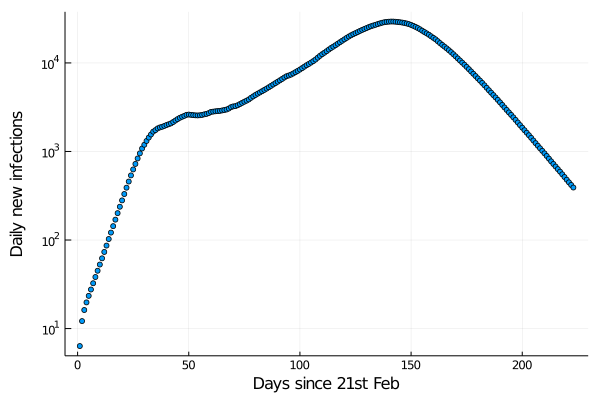

In [20]:
incidence = KenyaSerology.get_incidence(transmission_sol)
scatter(incidence,ms=3,xlabel = "Days since 21st Feb", ylabel = "Daily new infections",label = "",yscale = :log10)

For PCR detections we assumed that infected people couldn't be detected for 5 days after infection, then a rapid transition to maximum detectabilty folowed by a fairly slow decay towards becoming undecteable again (20 days after becoming detectable 50% of infected individuals are undetectable). For serology detections we assumed that dectectability increased linearly to its maximum over 5 + 21 days. For references behind these assumptions see the main manuscript.

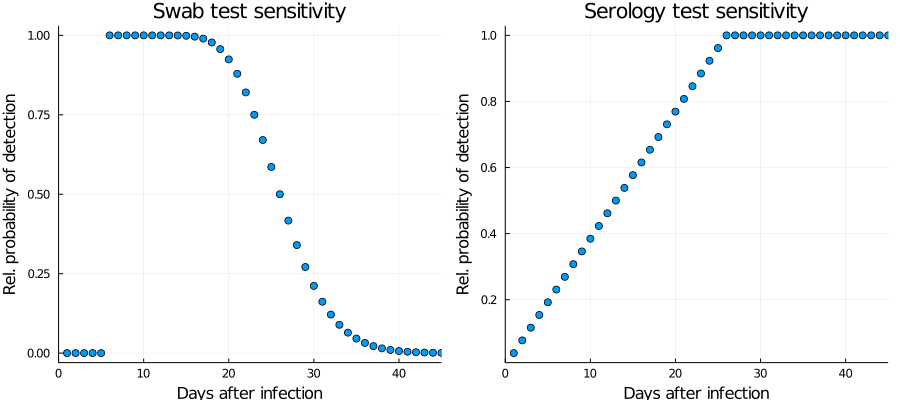

In [21]:
@load("data/default_PCR_detection_after_infection.jld2")
@load("data/rel_sero_detection_after_infection.jld2")
pltPCR = scatter(PCR_array,xlims = (0.,45.),lab ="",
                xlabel = "Days after infection",
                ylabel = "Rel. probability of detection",
                title = "Swab test sensitivity")
pltsero = scatter(rel_sero_array_26days,xlims = (0.,45.),lab ="",
                xlabel = "Days after infection",
                ylabel = "Rel. probability of detection",
                title = "Serology test sensitivity")
plot(pltPCR,pltsero,
    size = (900,400))

The maximum sensitivity of the swab test (in the typical setting that it was collected in Kenya) is absorbed into our detection rate parameter (see main text or later notebook). The number of individuals who would be detected if they took either test is a convolution over the daily new infection rate and the sensitivity over time profiles.

We calculated the solution to these convolutions using direct calculation `simple_conv`. For the sake of plotting we assume in this note that it is 90%, and don't include false positives. The reported maximum sensitivity of the serology test was 83%. We haven't included the possiblity of waning seropositivity over the predictive time-scale of this study. Below we present the predicted % of the population detectable by each test.

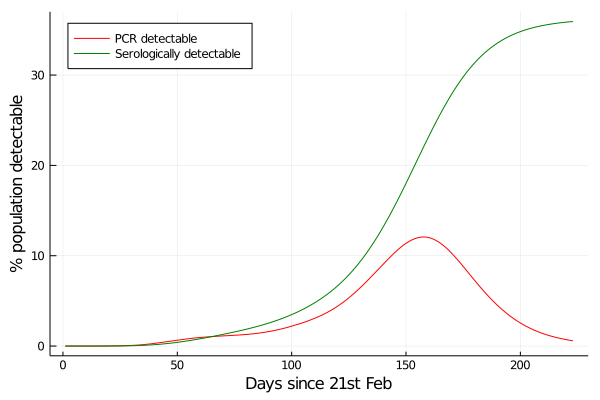

In [22]:
N_PCRdetectable = KenyaSerology.simple_conv(incidence,0.9*PCR_array)
N_serodetectable = KenyaSerology.simple_conv(incidence,0.83*rel_sero_array_26days)
plot(100*N_PCRdetectable/N,xlabel = "Days since 21st Feb", ylabel = "% population detectable",
    label = "PCR detectable",color = :red,legend = :topleft)
plot!(100*N_serodetectable/N,label="Serologically detectable",color = :green)

It should be noted that swab tests, in particular, are not typically used uniformly across the population and we would expect the % of PCR-positive tests among a group of patients with typical COVID symptoms to be higher than the % plotted above.

We don't use deaths to infer unknown parameters, but we do fit a crude observational IFR value and make predictions about the daily rate of deaths. The delay between infection and death (for those who die) is assumed to a convolution of distributions for infection-to-symptoms, symptoms-to-severe-symptoms and severe-symptoms-to-death (see main manuscript). Below we plot the overall infection to death lag distribution, alongside the convolution predictions for numbers who die each day (Verity 0.26% IFR and fitted 0.014% IFR).

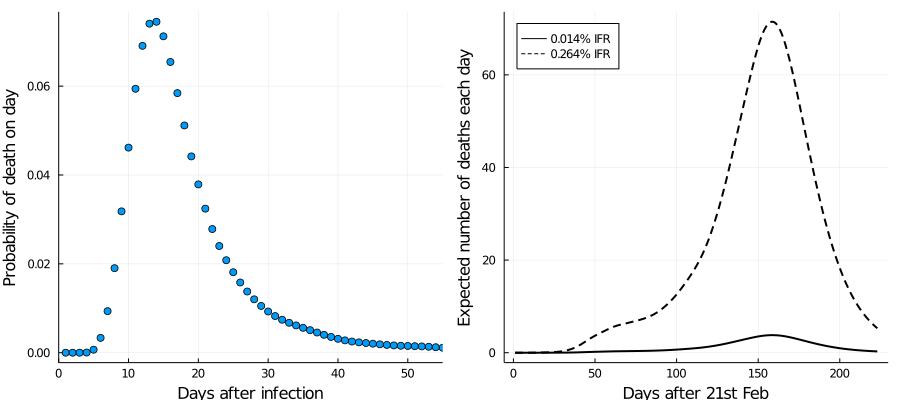

In [23]:
@load("data/p_ID.jld2")#Data file containing the convolution solution
pltdeath_prob = scatter(p_ID,xlims = (0.,55.),lab ="",
                xlabel = "Days after infection",
                ylabel = "Probability of death on day")
N_deaths_verity = KenyaSerology.simple_conv(incidence,0.00264*p_ID)
N_deaths_fit = KenyaSerology.simple_conv(incidence,0.00014*p_ID)
plt_deaths = plot(N_deaths_fit,lw=2,color=:black,lab = "0.014% IFR",
                xlabel = "Days after 21st Feb",
                ylabel = "Expected number of deaths each day",
                legend = :topleft)
plot!(plt_deaths,N_deaths_verity,lw=2,color=:black,ls=:dash,lab = "0.264% IFR")
plot(pltdeath_prob,plt_deaths,
        size = (900,400))